# NER Model Evaluation NER

## 1. Import dependencies

In [1]:
import json
import sys
import time
import warnings
from pathlib import Path
from typing import Dict, List, Tuple, Optional
from collections import defaultdict, Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Add project root to path for imports
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Deep learning imports
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel

# Custom imports
from src.data import load_processed_data
from src.prompt import build_prompt
from src.utils.evaluation import (
    parse_ner_response,
    compute_comprehensive_metrics,
    print_comprehensive_comparison
)

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')


## 2. Configuration


In [2]:
# Project paths
PROJECT_ROOT = Path.cwd().parent
DATA_DIR = PROJECT_ROOT / "data" / "vlps_2018_ner" / "processed"
MODELS_DIR = PROJECT_ROOT / "models"

# Model configuration
class Config:
    # Model paths
    base_model_name = "mistralai/Mistral-7B-Instruct-v0.3"
    finetuned_adapter_path = PROJECT_ROOT / "notebooks" / "checkpoints" / "mistral-7B-Instruct-v0.3-ner-qlora" / "final-adapters"
    
    # Inference config
    max_new_tokens = 512
    temperature = 0.1
    top_p = 0.95
    do_sample = False
    
    # Eval config
    entity_types = ['person', 'organizations', 'address']
    test_samples = 30

config = Config()

print("Configuration loaded")

Configuration loaded


## 3. Data Loading

In [3]:
# Load test data
print("Loading test data...")
data_splits = load_processed_data()
test_data = data_splits['test'][:config.test_samples]

print(f"Loaded {len(test_data)} test samples")
print("\nSample:")
sample = test_data[0]
print(f"  Text: {sample['text'][:100]}...")
print(f"  Entities: {sample['ground_truth']}")


Loading test data...
Loaded 30 test samples

Sample:
  Text: Học máy (machine learning) sẽ là công nghệ định hình năm 2018, góp phần thay đổi lối sống và làm việ...
  Entities: {'person': ['Chris Chelliah'], 'organizations': ['Gartner'], 'address': ['Thái Bình Dương', 'Châu Á Thái Bình Dương']}


## 4. Prompt Template

In [4]:
# Test prompt building
sample_prompt = build_prompt("Đây là một văn bản mẫu về Việt Nam.")
print("Sample prompt structure:")
print(sample_prompt[:200] + "...")


Sample prompt structure:
### Instruction:
You are a Vietnamese Named Entity Recognition (NER) expert. Extract named entities from the given text and classify them into three categories:
- person: Names of people
- organizatio...


## 5. Model Loading Functions

In [5]:
def load_base_model():
    """Load base model with 4-bit quantization"""
    from transformers import BitsAndBytesConfig
    
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.float16,
        bnb_4bit_use_double_quant=True
    )
    
    print("Loading base model...")
    model = AutoModelForCausalLM.from_pretrained(
        config.base_model_name,
        quantization_config=bnb_config,
        device_map="auto",
        trust_remote_code=False
    )
    
    tokenizer = AutoTokenizer.from_pretrained(
        config.base_model_name,
        trust_remote_code=False
    )
    
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    
    model.eval()
    print("Base model loaded successfully")
    
    return model, tokenizer


def load_finetuned_model():
    """Load fine-tuned model with QLoRA adapter"""
    from transformers import BitsAndBytesConfig
    
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.float16,
        bnb_4bit_use_double_quant=True
    )
    
    print("Loading fine-tuned model...")
    base_model = AutoModelForCausalLM.from_pretrained(
        config.base_model_name,
        quantization_config=bnb_config,
        device_map="auto",
        trust_remote_code=False
    )
    
    # Load adapter
    model = PeftModel.from_pretrained(base_model, str(config.finetuned_adapter_path))
    
    tokenizer = AutoTokenizer.from_pretrained(
        config.base_model_name,
        trust_remote_code=False
    )
    
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    
    model.eval()
    print("Fine-tuned model loaded successfully")
    
    return model, tokenizer


## 6. Inference Functions

In [6]:
def generate_prediction(
    model,
    tokenizer,
    text: str,
    return_time: bool = False
) -> Dict:
    """Generate NER prediction for a single text
    
    Returns:
        Dict with entity predictions or error info
    """
    try:
        start_time = time.time()
        
        # Build prompt and tokenize
        prompt = build_prompt(text)
        inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=2048)
        inputs = {k: v.to(model.device) for k, v in inputs.items()}
        
        # Generate
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=config.max_new_tokens,
                temperature=config.temperature,
                top_p=config.top_p,
                do_sample=config.do_sample,
                pad_token_id=tokenizer.pad_token_id,
                eos_token_id=tokenizer.eos_token_id
            )
        
        # Decode and parse
        generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        response_text = generated_text.split("### Response:")[-1].strip()
        parsed_entities = parse_ner_response(response_text)
        
        elapsed_time = time.time() - start_time
        
        if return_time:
            return parsed_entities, elapsed_time
        return parsed_entities
        
    except Exception as e:
        print(f"Error in prediction: {str(e)}")
        default_result = {"person": [], "organizations": [], "address": []}
        if return_time:
            return default_result, 0.0
        return default_result


def batch_predict(
    model,
    tokenizer,
    examples: List[Dict],
    model_name: str = "Model"
) -> Tuple[List[Dict], List[float]]:
    """Generate predictions for multiple examples
    
    Returns:
        Tuple of (predictions, inference_times)
    """
    predictions = []
    times = []
    
    print(f"\nGenerating predictions with {model_name}...")
    for i, example in enumerate(examples):
        pred, time_taken = generate_prediction(
            model, tokenizer, example['text'], return_time=True
        )
        predictions.append(pred)
        times.append(time_taken)
        
        if (i + 1) % 5 == 0:
            print(f"  Completed: {i + 1}/{len(examples)}")
    
    print(f"\n{model_name} predictions completed.")
    print(f"  Generated {len(predictions)} predictions")
    print(f"  Average inference time: {sum(times)/len(times):.3f}s per example")
    
    return predictions, times


## 7. Load Models and Generate Predictions

In [7]:
# Generate base model predictions
base_model, base_tokenizer = load_base_model()

base_predictions, base_times = batch_predict(
    base_model,
    base_tokenizer,
    test_data,
    "Base Model"
)


Loading base model...


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Base model loaded successfully

Generating predictions with Base Model...
  Completed: 5/30
  Completed: 10/30
  Completed: 15/30
  Completed: 20/30
  Completed: 25/30
  Completed: 30/30

Base Model predictions completed.
  Generated 30 predictions
  Average inference time: 4.817s per example


# 8. Generate fine-tuned model predictions


In [8]:
# Load fine-tuned model and generate predictions
finetuned_model, finetuned_tokenizer = load_finetuned_model()

finetuned_predictions, finetuned_times = batch_predict(
    finetuned_model,
    finetuned_tokenizer,
    test_data,
    "Fine-tuned Model (QLoRA)"
)

print(f"\nFine-tuned model predictions completed.")
print(f"  Generated {len(finetuned_predictions)} predictions")
print(f"  Average inference time: {sum(finetuned_times)/len(finetuned_times):.3f}s per example")

Loading fine-tuned model...


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Fine-tuned model loaded successfully

Generating predictions with Fine-tuned Model (QLoRA)...
  Completed: 5/30
  Completed: 10/30
  Completed: 15/30
  Completed: 20/30
  Completed: 25/30
  Completed: 30/30

Fine-tuned Model (QLoRA) predictions completed.
  Generated 30 predictions
  Average inference time: 22.977s per example

Fine-tuned model predictions completed.
  Generated 30 predictions
  Average inference time: 22.977s per example


# 9. Compute comprehensive metrics

In [9]:
# Extract ground truths
ground_truths = [example['ground_truth'] for example in test_data]

# Compute comprehensive metrics for both models
print("Computing comprehensive metrics...")

# Use compute_comprehensive_metrics() which supports similarity_threshold
base_comprehensive = compute_comprehensive_metrics(
    base_predictions, 
    ground_truths, 
    entity_types=config.entity_types,
    similarity_threshold=0.8
)

finetuned_comprehensive = compute_comprehensive_metrics(
    finetuned_predictions, 
    ground_truths, 
    entity_types=config.entity_types,
    similarity_threshold=0.8
)

print("\nMetrics computation completed.")
print(f"  Base model - Exact Match: {base_comprehensive['percentage']}")
print(f"  Base model - Overall F1: {base_comprehensive['overall_entity_metrics']['f1_pct']}")
print(f"  Fine-tuned model - Exact Match: {finetuned_comprehensive['percentage']}")
print(f"  Fine-tuned model - Overall F1: {finetuned_comprehensive['overall_entity_metrics']['f1_pct']}")

Computing comprehensive metrics...

Metrics computation completed.
  Base model - Exact Match: 3.3%
  Base model - Overall F1: 33.3%
  Fine-tuned model - Exact Match: 6.7%
  Fine-tuned model - Overall F1: 47.5%


# 10. Print comprehensive comparison


In [10]:
# Create comprehensive results dictionary for comparison
comparison_results = {
    'Base Model': base_comprehensive,
    'Fine-tuned Model (QLoRA)': finetuned_comprehensive
}

# Display professional comparison table (using imported function)
print_comprehensive_comparison(comparison_results, entity_types=config.entity_types)

# Create detailed comparison DataFrame for visualization
comparison_data = []

for entity_type in config.entity_types:
    base_m = base_comprehensive['per_entity_type'][entity_type]
    ft_m = finetuned_comprehensive['per_entity_type'][entity_type]
    
    comparison_data.append({
        'Entity Type': entity_type.replace('_', ' ').title(),
        'Base P': base_m['precision'],
        'Base R': base_m['recall'],
        'Base F1': base_m['f1'],
        'FT P': ft_m['precision'],
        'FT R': ft_m['recall'],
        'FT F1': ft_m['f1'],
        'Delta P': ft_m['precision'] - base_m['precision'],
        'Delta R': ft_m['recall'] - base_m['recall'],
        'Delta F1': ft_m['f1'] - base_m['f1']
    })

# Add overall metrics
base_overall = base_comprehensive['overall_entity_metrics']
ft_overall = finetuned_comprehensive['overall_entity_metrics']

comparison_data.append({
    'Entity Type': 'Overall',
    'Base P': base_overall['precision'],
    'Base R': base_overall['recall'],
    'Base F1': base_overall['f1'],
    'FT P': ft_overall['precision'],
    'FT R': ft_overall['recall'],
    'FT F1': ft_overall['f1'],
    'Delta P': ft_overall['precision'] - base_overall['precision'],
    'Delta R': ft_overall['recall'] - base_overall['recall'],
    'Delta F1': ft_overall['f1'] - base_overall['f1']
})

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*120)
print("DETAILED PERFORMANCE COMPARISON: BASE MODEL VS FINE-TUNED MODEL")
print("="*120)
print("\nNote: P=Precision, R=Recall, F1=F1-Score, FT=Fine-tuned, Delta=Improvement")
print()
display(comparison_df.style.format({
    'Base P': '{:.2f}', 'Base R': '{:.2f}', 'Base F1': '{:.2f}',
    'FT P': '{:.2f}', 'FT R': '{:.2f}', 'FT F1': '{:.2f}',
    'Delta P': '{:+.2f}', 'Delta R': '{:+.2f}', 'Delta F1': '{:+.2f}'
}).background_gradient(subset=['Delta F1'], cmap='RdYlGn', vmin=-10, vmax=10))

# Highlight key improvements
print("\n" + "="*120)
print("KEY IMPROVEMENTS")
print("="*120)
print(f"\n{'Entity Type':<25} {'Delta Precision':<30} {'Delta Recall':<30} {'Delta F1':<30}")
print("-"*120)
for _, row in comparison_df.iterrows():
    if abs(row['Delta F1']) > 0.01:  # Show changes > 0.01%
        improvement_marker = "↑" if row['Delta F1'] > 0 else "↓"
        print(f"{row['Entity Type']:<25} {improvement_marker} {row['Delta P']:+.2f}% ({row['Delta P']:+.2f}pp)"
              f"       {improvement_marker} {row['Delta R']:+.2f}% ({row['Delta R']:+.2f}pp)"
              f"       {improvement_marker} {row['Delta F1']:+.2f}% ({row['Delta F1']:+.2f}pp)")



COMPREHENSIVE EVALUATION RESULTS

OVERALL EXACT MATCH ACCURACY:
----------------------------------------------------------------------------------------------------
Method                    Accuracy        Correct/Total       
----------------------------------------------------------------------------------------------------
Base Model                3.3%            1/30                  
Fine-tuned Model (QLoRA)  6.7%            2/30                  

OVERALL ENTITY-LEVEL METRICS:
----------------------------------------------------------------------------------------------------
Method                    Precision       Recall          F1-Score       
----------------------------------------------------------------------------------------------------
Base Model                66.2%           22.3%           33.3%          
Fine-tuned Model (QLoRA)  75.3%           34.7%           47.5%          

PER-ENTITY-TYPE METRICS:
-----------------------------------------------------------

,Entity Type,Base P,Base R,Base F1,FT P,FT R,FT F1,Delta P,Delta R,Delta F1
0,Person,77.78,14.58,24.56,86.36,39.58,54.29,+8.59,+25.00,+29.72
1,Organizations,66.67,32.32,43.54,65.91,29.29,40.56,-0.76,-3.03,-2.98
2,Address,50.00,8.70,14.81,82.61,41.30,55.07,+32.61,+32.61,+40.26
3,Overall,66.15,22.28,33.33,75.28,34.72,47.52,+9.13,+12.44,+14.18



KEY IMPROVEMENTS

Entity Type               Delta Precision                Delta Recall                   Delta F1                      
------------------------------------------------------------------------------------------------------------------------
Person                    ↑ +8.59% (+8.59pp)       ↑ +25.00% (+25.00pp)       ↑ +29.72% (+29.72pp)
Organizations             ↓ -0.76% (-0.76pp)       ↓ -3.03% (-3.03pp)       ↓ -2.98% (-2.98pp)
Address                   ↑ +32.61% (+32.61pp)       ↑ +32.61% (+32.61pp)       ↑ +40.26% (+40.26pp)
Overall                   ↑ +9.13% (+9.13pp)       ↑ +12.44% (+12.44pp)       ↑ +14.18% (+14.18pp)


# 11. Visualize metrics comparison

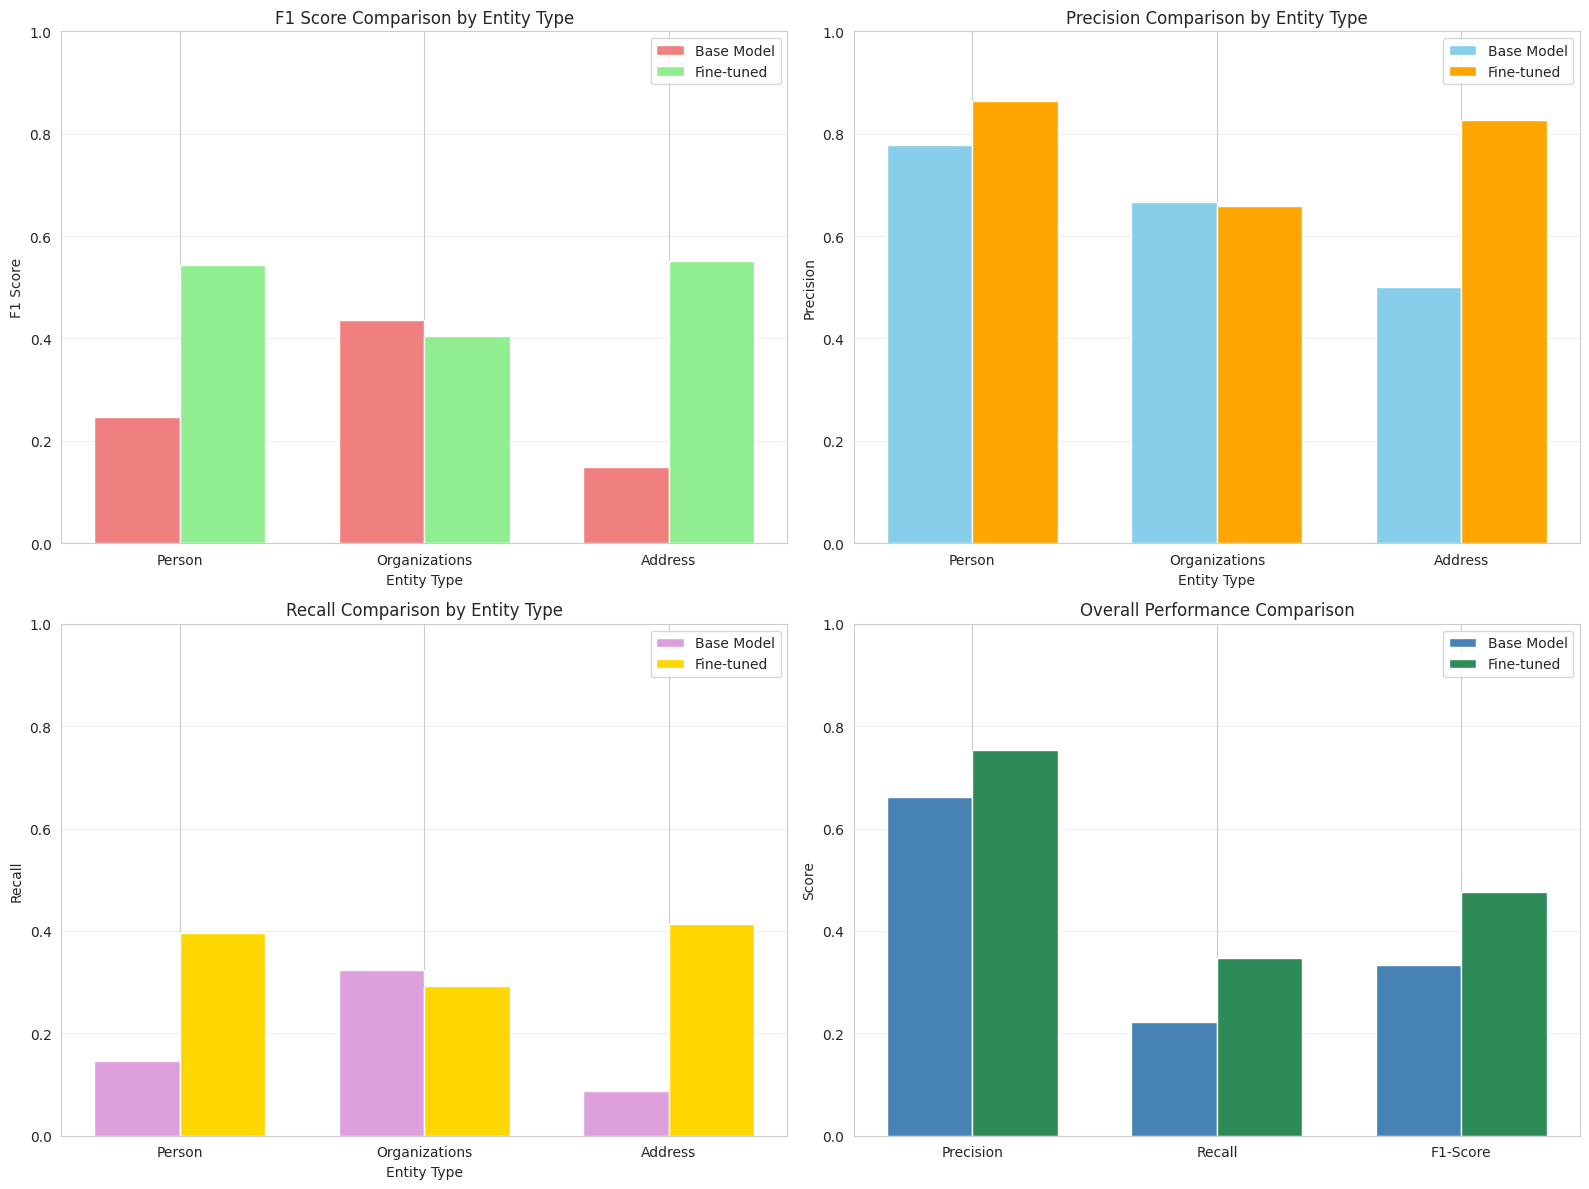

In [11]:
# Visualize metric comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Extract per-entity-type metrics from comprehensive results
base_metrics = base_comprehensive['per_entity_type']
finetuned_metrics = finetuned_comprehensive['per_entity_type']

# F1 Score comparison
entity_types_display = [et.replace('_', ' ').title() for et in config.entity_types]
x = np.arange(len(config.entity_types))
width = 0.35

# Convert percentages (0-100) to ratios (0-1) for visualization
base_f1 = [base_metrics[et]['f1'] / 100 for et in config.entity_types]
ft_f1 = [finetuned_metrics[et]['f1'] / 100 for et in config.entity_types]

axes[0, 0].bar(x - width/2, base_f1, width, label='Base Model', color='lightcoral')
axes[0, 0].bar(x + width/2, ft_f1, width, label='Fine-tuned', color='lightgreen')
axes[0, 0].set_xlabel('Entity Type')
axes[0, 0].set_ylabel('F1 Score')
axes[0, 0].set_title('F1 Score Comparison by Entity Type')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(entity_types_display)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')
axes[0, 0].set_ylim(0, 1)

# Precision comparison
base_p = [base_metrics[et]['precision'] / 100 for et in config.entity_types]
ft_p = [finetuned_metrics[et]['precision'] / 100 for et in config.entity_types]

axes[0, 1].bar(x - width/2, base_p, width, label='Base Model', color='skyblue')
axes[0, 1].bar(x + width/2, ft_p, width, label='Fine-tuned', color='orange')
axes[0, 1].set_xlabel('Entity Type')
axes[0, 1].set_ylabel('Precision')
axes[0, 1].set_title('Precision Comparison by Entity Type')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(entity_types_display)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='y')
axes[0, 1].set_ylim(0, 1)

# Recall comparison
base_r = [base_metrics[et]['recall'] / 100 for et in config.entity_types]
ft_r = [finetuned_metrics[et]['recall'] / 100 for et in config.entity_types]

axes[1, 0].bar(x - width/2, base_r, width, label='Base Model', color='plum')
axes[1, 0].bar(x + width/2, ft_r, width, label='Fine-tuned', color='gold')
axes[1, 0].set_xlabel('Entity Type')
axes[1, 0].set_ylabel('Recall')
axes[1, 0].set_title('Recall Comparison by Entity Type')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(entity_types_display)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')
axes[1, 0].set_ylim(0, 1)

# Overall metrics comparison
base_overall_metrics = base_comprehensive['overall_entity_metrics']
ft_overall_metrics = finetuned_comprehensive['overall_entity_metrics']

metrics_names = ['Precision', 'Recall', 'F1-Score']
base_overall = [
    base_overall_metrics['precision'] / 100,
    base_overall_metrics['recall'] / 100,
    base_overall_metrics['f1'] / 100
]
ft_overall = [
    ft_overall_metrics['precision'] / 100,
    ft_overall_metrics['recall'] / 100,
    ft_overall_metrics['f1'] / 100
]

x_overall = np.arange(len(metrics_names))
axes[1, 1].bar(x_overall - width/2, base_overall, width, label='Base Model', color='steelblue')
axes[1, 1].bar(x_overall + width/2, ft_overall, width, label='Fine-tuned', color='seagreen')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_title('Overall Performance Comparison')
axes[1, 1].set_xticks(x_overall)
axes[1, 1].set_xticklabels(metrics_names)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')
axes[1, 1].set_ylim(0, 1)

plt.tight_layout()
plt.show()



# 12. Compare inference speeds



INFERENCE SPEED COMPARISON


,Model,Mean Time (s),Std Time (s),Median Time (s),Min Time (s),Max Time (s)
0,Base Model,4.816598,2.958086,3.816998,1.282261,13.237016
1,Fine-tuned Model,22.976623,0.194275,22.924805,22.725132,23.416303


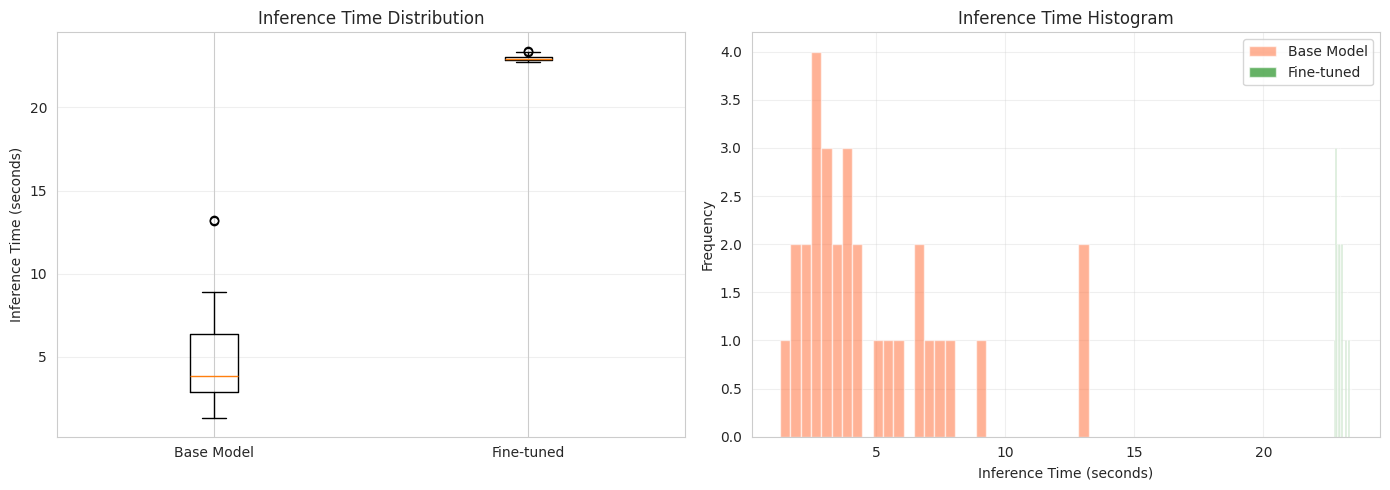

In [12]:
# Compare inference speeds
speed_comparison = pd.DataFrame({
    'Model': ['Base Model', 'Fine-tuned Model'],
    'Mean Time (s)': [np.mean(base_times), np.mean(finetuned_times)],
    'Std Time (s)': [np.std(base_times), np.std(finetuned_times)],
    'Median Time (s)': [np.median(base_times), np.median(finetuned_times)],
    'Min Time (s)': [np.min(base_times), np.min(finetuned_times)],
    'Max Time (s)': [np.max(base_times), np.max(finetuned_times)],
})

print("\n" + "="*80)
print("INFERENCE SPEED COMPARISON")
print("="*80)
display(speed_comparison)

# Visualize speed distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot
axes[0].boxplot([base_times, finetuned_times], labels=['Base Model', 'Fine-tuned'])
axes[0].set_ylabel('Inference Time (seconds)')
axes[0].set_title('Inference Time Distribution')
axes[0].grid(True, alpha=0.3, axis='y')

# Histogram
axes[1].hist(base_times, bins=30, alpha=0.6, label='Base Model', color='coral')
axes[1].hist(finetuned_times, bins=30, alpha=0.6, label='Fine-tuned', color='green')
axes[1].set_xlabel('Inference Time (seconds)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Inference Time Histogram')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
